In [1]:
### DO NOT SHUT DOWN, CURRENTLY IN USE

# Imports

import sys
sys.path.append("../MaskTrack_RCNN")

# note: uses tensorflow, may cause issues
from project.optical_flow_old import OpticalFlow

import numpy as np
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import cv2
import glob
from tqdm import tqdm

In [2]:
# DAVIS dataset API

from sklearn.model_selection import train_test_split


##################################################################
#
# Usage:
# dataset = DavisDataset("DAVIS", "480p") 
#
##################################################################


class DavisDataset(object):
  
    # TODO: in init include way to download dataset
    # include download link and expected directory structure
  
    def __init__(self, directory, quality):
        
        """
        
        self.frame_pairs = an array of tuples of the form:
        (img_prev, img_curr, mask_prev, mask_curr) PATHS
        
        """
        
        # generate mask pairs
        
        self.frame_pairs = [] # tuples of image and masks at t-1 and t
        
        image_dir = "%s/JPEGImages/%s/" % (directory, quality)
        mask_dir = "%s/Annotations/%s/" % (directory, quality)
        
        videos = [x[len(image_dir):] for x in glob.glob(image_dir + "*")]
        
        for video in videos:
      
            frames = [x[len(image_dir) + len(video) + 1:-4] for x in glob.glob(image_dir + video + "/*")]
            frames.sort()
      
            for prev, curr in zip(frames[:-1], frames[1:]):
        
                image_prev = image_dir + video + "/" + prev + ".jpg"
                image_curr = image_dir + video + "/" + curr + ".jpg"
                mask_prev = mask_dir + video + "/" + prev + ".png"
                mask_curr = mask_dir + video + "/" + curr + ".png"
      
                self.frame_pairs.append( (image_prev, image_curr, mask_prev, mask_curr) )
  
    def plot_random_frame_and_mask(self, frame_pair):
        fig, axarr = plt.subplots(3,2)
        fig.set_size_inches(16, 16)
        mask_prev = io.imread(frame_pair[2])
        mask_curr = io.imread(frame_pair[3])
        axarr[0][0].set_title("Image Prev")
        axarr[0][0].imshow(io.imread(frame_pair[0]))
        axarr[0][1].set_title("Image Curr")
        axarr[0][1].imshow(io.imread(frame_pair[1]))
        axarr[1][0].set_title("Mask Prev")
        axarr[1][0].imshow(mask_prev)
        axarr[1][1].set_title("Mask Curr")
        axarr[1][1].imshow(mask_curr)
        axarr[2][0].set_title("In Prev Mask, Not in Curr")
        axarr[2][0].imshow( (mask_prev == 255) & (mask_curr != 255) )
        axarr[2][1].set_title("In Curr Mask, Not in Prev")
        axarr[2][1].imshow( (mask_prev != 255) & (mask_curr == 255) )
    
    def get_train_val(self, val_size = 0.0, random_state = 42):
    
        frame_pairs = self.frame_pairs.copy()
        np.random.shuffle(frame_pairs)
    
        train, val = train_test_split(frame_pairs, test_size = val_size, random_state = random_state)
        return train, val

In [3]:
dataset = DavisDataset("DAVIS", "480p")
train, val = dataset.get_train_val(val_size=0.2)

print(len(train))
print(len(val))

2724
681


In [4]:
opticalflow = OpticalFlow("../MaskTrack_RCNN/pwc_net/model_3000epoch/model_3007.ckpt")

Level 0
Level 1
Level 2
Level 3
Level 4
Finally upscale flow by 4.
INFO:tensorflow:Restoring parameters from ../MaskTrack_RCNN/pwc_net/model_3000epoch/model_3007.ckpt


In [21]:
from sklearn.preprocessing import MinMaxScaler

def pad_image(image):
    # for davis, opitcal flow output always maps (480, 854) -> (480, 864)
    # for UNET, both dimensions must be a multiple of 8
    return cv2.copyMakeBorder(image, 0 , 0, 5, 5, cv2.BORDER_CONSTANT, value=0)

def get_model_input(img_prev, img_curr, mask_prev, mask_curr):
    
    """
    
    Returns tensor that contains previous mask and optical flow, and also
    returns current mask as the ground truth value.
    """
    
    # optical flow
    img_prev, img_curr = opticalflow.read_images_from_path(img_prev, img_curr)
    img_prev, img_curr = pad_image(img_prev), pad_image(img_curr)
    img_prev, img_curr, finalflow, flows, pyramid_0 = opticalflow.get_flow(img_prev, img_curr, resize=False)
    
    # masks
    mask_prev = pad_image(io.imread(mask_prev)) / 255
    mask_curr = pad_image(io.imread(mask_curr)) / 255
    
    # scale to bring between 0 and 1
    finalflow[:, :, 0] = MinMaxScaler().fit_transform(finalflow[:, :, 0])
    finalflow[:, :, 1] = MinMaxScaler().fit_transform(finalflow[:, :, 1])

    model_input = np.stack([mask_prev, finalflow[:, :, 0], finalflow[:, :, 1]], axis=2)
    
    return model_input, mask_curr

In [6]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

input_shape = (480, 864, 3)
inputs = Input(input_shape)

conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
merge6 = merge([drop4, up6], mode='concat', concat_axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
merge7 = merge([conv3, up7], mode='concat', concat_axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
merge8 = merge([conv2, up8], mode='concat', concat_axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
merge9 = merge([conv1, up9], mode='concat', concat_axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
model = Model(input=inputs, output=conv10)
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# ^ try using learning rate finder

Using TensorFlow backend.
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/shared/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/shar

In [10]:
# Train the model

# threw an error because dimensions didn't match in np.stack
# which means that mask and optical flow did not have the same dims
def create_dataset(dataset):
    X = []
    y = []
    for sample in tqdm(dataset):
        model_input, ground_truth = get_model_input(*sample)
        X.append(model_input)
        y.append(np.expand_dims(ground_truth, axis=3))
    X = np.array(X)
    y = np.array(y)
    print(X.shape)
    print(y.shape)
    return X, y

X_train, y_train = create_dataset(train[:100])
X_val, y_val = create_dataset(val[:20])


  0%|          | 0/100 [00:00<?, ?it/s]/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if __name__ == '__main__':

100%|██████████| 100/100 [00:08<00:00, 11.45it/s]

 10%|█         | 2/20 [00:00<00:01, 11.45it/s]

(100, 480, 864, 3)
(100, 480, 864, 1)



100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


(20, 480, 864, 3)
(20, 480, 864, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 128 ms, sys: 3.8 ms, total: 132 ms
Wall time: 104 ms


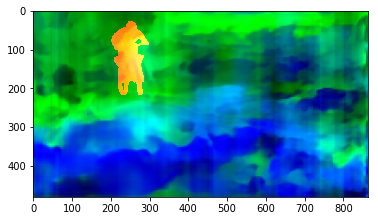

In [86]:
%%time
# Pretraining inference
test_input, test_ground_truth = get_model_input(*(train[85]))

plt.imshow(test_input)

(1, 480, 864, 1)
CPU times: user 181 ms, sys: 43.5 ms, total: 224 ms
Wall time: 107 ms


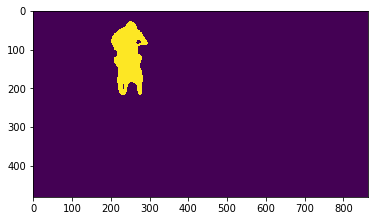

In [87]:
%%time
inference = model.predict(np.expand_dims(test_input, axis=0))
print(inference.shape)

plt.imshow(inference.reshape(480, 864) > 0.5)

In [13]:
model.fit(X_train, y_train, batch_size=4, epochs=10, validation_data=(X_val, y_val))

Train on 100 samples, validate on 20 samples
Epoch 1/10
100/100 [==============================] - 36s 360ms/step - loss: 0.7330 - acc: 0.7563 - val_loss: 0.6922 - val_acc: 0.9119
Epoch 2/10
100/100 [==============================] - 31s 307ms/step - loss: 0.6917 - acc: 0.9202 - val_loss: 0.6912 - val_acc: 0.9119
Epoch 3/10
100/100 [==============================] - 31s 306ms/step - loss: 0.6906 - acc: 0.9202 - val_loss: 0.6901 - val_acc: 0.9119
Epoch 4/10
100/100 [==============================] - 31s 306ms/step - loss: 0.6896 - acc: 0.9202 - val_loss: 0.6891 - val_acc: 0.9119
Epoch 5/10
100/100 [==============================] - 31s 306ms/step - loss: 0.6886 - acc: 0.9202 - val_loss: 0.6881 - val_acc: 0.9119
Epoch 6/10
100/100 [==============================] - 31s 307ms/step - loss: 0.6875 - acc: 0.9202 - val_loss: 0.6871 - val_acc: 0.9119
Epoch 7/10
100/100 [==============================] - 31s 306ms/step - loss: 0.6865 - acc: 0.9202 - val_loss: 0.6861 - val_acc: 0.9119
Epoch 8/10

In [22]:
def plot_prediction(frame_pair, pred_mask):
    
    fig, axarr = plt.subplots(4,2)
    fig.set_size_inches(32, 16)
    
    img_prev = pad_image(io.imread(frame_pair[0]))
    img_curr = pad_image(io.imread(frame_pair[1]))
    mask_prev = pad_image(io.imread(frame_pair[2]))
    mask_curr = pad_image(io.imread(frame_pair[3]))
    
    axarr[0][0].set_title("Image Prev")
    axarr[0][1].set_title("Image Curr")
    axarr[1][0].set_title("Mask Prev")
    axarr[1][1].set_title("Mask Curr")
    axarr[2][0].set_title("In Prev not in Curr")
    axarr[2][1].set_title("In Curr not in Prev")
    axarr[3][0].set_title("Pred Mask Curr")
    axarr[3][1].set_title("Difference Btwn Curr and Pred")
    
    axarr[0][0].imshow(img_prev)
    axarr[0][1].imshow(img_curr)
    axarr[1][0].imshow(mask_prev)
    axarr[1][1].imshow(mask_curr)
    axarr[2][0].imshow( (mask_prev == 255) & (mask_curr != 255) )
    axarr[2][1].imshow( (mask_prev != 255) & (mask_curr == 255) )
    axarr[3][0].imshow(pred_mask)
    axarr[3][1].imshow( (pred_mask == 255) & (mask_curr != 255) )

[[[[ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]
   ..., 
   [ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]]

  [[ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]
   ..., 
   [ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]]

  [[ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]
   ..., 
   [ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]]

  ..., 
  [[ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]
   ..., 
   [ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]]

  [[ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]
   ..., 
   [ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]]

  [[ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]
   ..., 
   [ 0.49384108]
   [ 0.49384108]
   [ 0.49384108]]]]


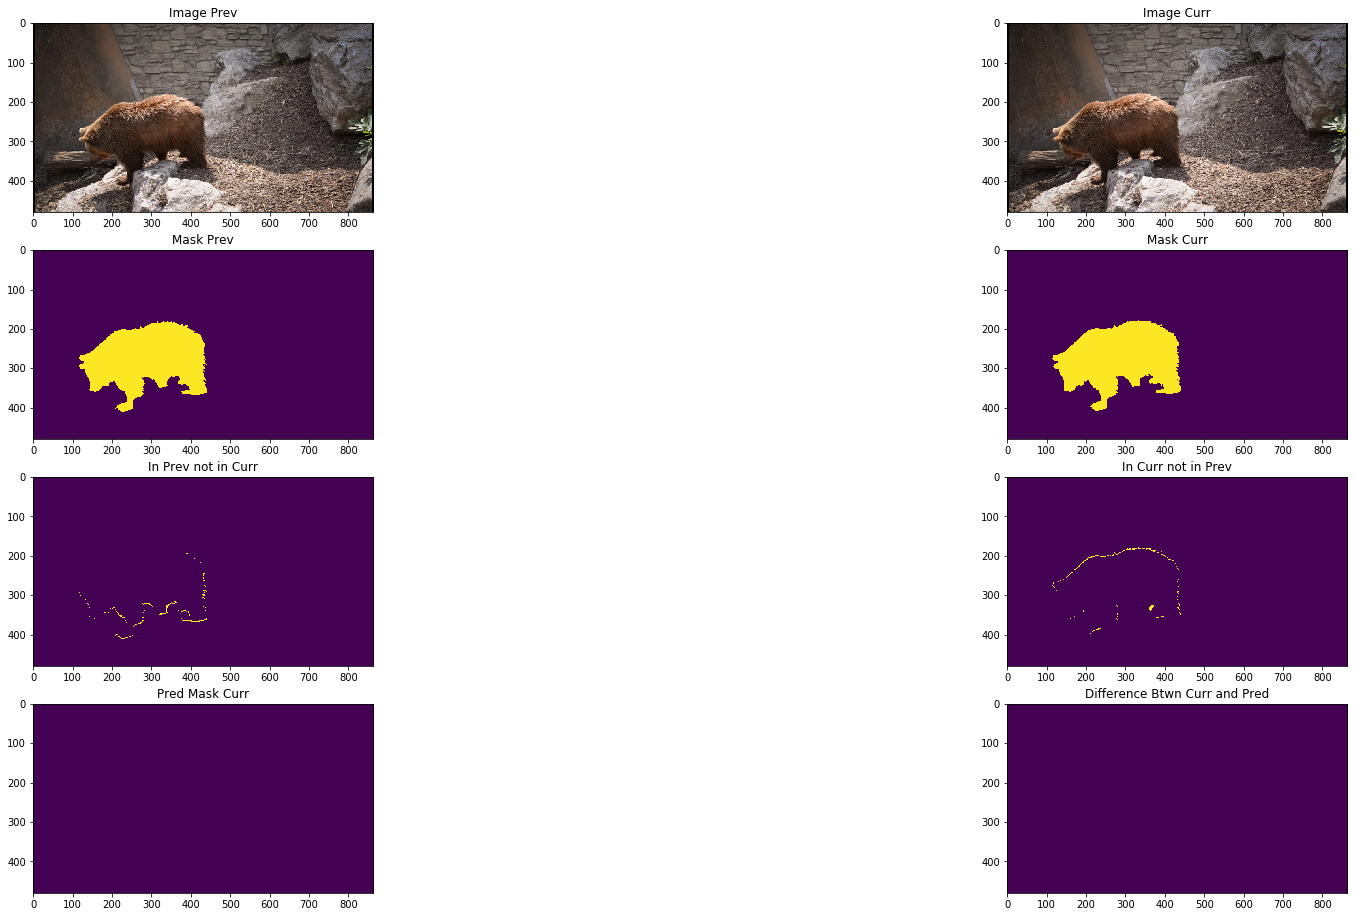

In [26]:
test_sample = val[15]
test_input, test_ground_truth = get_model_input(*test_sample)
inference = model.predict(np.expand_dims(test_input, axis=0))
print(inference)
inference = inference.reshape(480, 864) > 0.5
plot_prediction(test_sample, inference)